<a href="https://colab.research.google.com/github/serrve1/ubion_project1/blob/main/%EA%B2%BD%EA%B8%B0%EA%B5%AD%EB%A9%B4%EB%B3%84_MVO%EB%AA%A8%EB%8D%B8_(3%EA%B5%AD%EB%A9%B4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # 한글 폰트 설정 => 런타임 다시 시작 후 실행
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !pip install html_table_parser# 한글 나눔 폰트

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (11.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121730 files and direc

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 경로 등록
fontprop = fm.FontProperties(fname=font_path, size=12)

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
# 세부자산군 예를들어 미국주식이면 S&P, 나스닥, 러셀 등등은 우리가 직접 정할 것, 상관계수가 너무 높아 MVO를 돌리면 코너해 문제 발생
# 대표자산군 5개 가져오기 1. GSCI(원자재) 2. S&P500(미국주식)  3. 코스피(한국주식)4. 미국10년만기채(미국주식)  5. 한국국채(데이터 넣기)
# 1. 과거 특정 국면 데이터 수집
assets = ['원자재','S&P500','코스피','미국중기채']
ticker = ['^SPGSCI', '^GSPC', '^KS11','^FVX']
st = {}

# 데이터 수집 시기를 확인
for i, t in enumerate(ticker):
    data = yf.download(t , '2000-01-01', '2023-12-31')
    st[assets[i]] = data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# 한국은행 국고채 5년
한국중기채 = pd.read_csv('/content/drive/MyDrive/프로젝트1/dataset/한국국채5년.csv',encoding = 'CP949')
한국중기채['Date'] = pd.to_datetime(한국중기채['Date'])
한국중기채.dropna(inplace=True)

In [6]:
원자재 = pd.DataFrame()
US500 = pd.DataFrame()
코스피 = pd.DataFrame()
미국중기채 = pd.DataFrame()

원자재['원자재'] = st[assets[0]]['Adj Close']
US500['US500'] = st[assets[1]]['Adj Close']
코스피['코스피'] = st[assets[2]]['Adj Close']
미국중기채['미국중기채'] = st[assets[3]]['Adj Close']
한국중기채['한국중기채'] = 한국중기채['Adj Close']
df_asset= pd.concat([원자재, US500, 미국중기채],axis = 1)
df_asset.reset_index('Date',inplace = True)
코스피.reset_index('Date',inplace = True)
# 코스피 시차조정 미국의 1월1일 = 한국의 1월 2일, 미국 기준으로 시차 조정
df_asset = pd.merge(df_asset, 코스피, on='Date', how='inner')
df_asset = pd.merge(df_asset, 한국중기채, on = 'Date' , how ='inner' )
# 코스피,한국중기채 시차조정 미국의 1월1일 = 한국의 1월 2일, 미국 기준으로 시차 조정
df_asset['코스피'] = df_asset['코스피'].shift(-1).fillna(method = 'ffill')
df_asset['한국중기채'] = df_asset['한국중기채'].shift(-1).fillna(method = 'ffill')
df_asset = df_asset[['Date','원자재','US500','코스피','미국중기채','한국중기채']]

In [7]:
# 결측치 확인
df_asset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5732 entries, 0 to 5731
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5732 non-null   datetime64[ns]
 1   원자재     5732 non-null   float64       
 2   US500   5732 non-null   float64       
 3   코스피     5732 non-null   float64       
 4   미국중기채   5725 non-null   float64       
 5   한국중기채   5732 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 313.5 KB


In [8]:
# 결측치 확인
df_asset = df_asset[df_asset.isnull().any(axis = 1) == False ]

In [9]:
# 데이터 프레임 출력
df_asset.head()

,Date,원자재,US500,코스피,미국중기채,한국중기채
0,2000-01-04,192.369995,1399.420044,986.309998,6.396,10.12
1,2000-01-05,190.520004,1402.109985,960.789978,6.489,10.16
2,2000-01-06,190.419998,1403.449951,948.650024,6.450,10.16
3,2000-01-07,188.550003,1441.469971,987.239990,6.397,10.20
4,2000-01-10,189.830002,1457.599976,981.330017,6.459,10.22


In [10]:
df_asset['미국중기채'] = df_asset['미국중기채']/100
df_asset['한국중기채'] = df_asset['한국중기채']/100

###군집화를 통해 나누어진 국면들
- 0국면 : 2014-12-31 ~ 2019-12-31
- 1국면 : 2001-01-31 ~ 2005-02-28
- 2국면 : 2009-05-31 ~ 2014-11-30
- 3국면 : 2000-01-31 ~ 2000.12~31,
- 3국면-2 : 2005-03-31 ~ 2007-10-31
- 4국면 : 2007-11-30 ~ 2009-04-30

In [11]:
df_asset

,Date,원자재,US500,코스피,미국중기채,한국중기채
0,2000-01-04,192.369995,1399.420044,986.309998,0.06396,0.10120
1,2000-01-05,190.520004,1402.109985,960.789978,0.06489,0.10160
2,2000-01-06,190.419998,1403.449951,948.650024,0.06450,0.10160
3,2000-01-07,188.550003,1441.469971,987.239990,0.06397,0.10200
4,2000-01-10,189.830002,1457.599976,981.330017,0.06459,0.10220
...,...,...,...,...,...,...
5727,2023-12-21,543.789978,4746.750000,2599.510010,0.03882,0.03254
5728,2023-12-22,543.729980,4754.629883,2602.590088,0.03879,0.03227
5729,2023-12-26,551.150024,4774.750000,2613.500000,0.03875,0.03222
5730,2023-12-27,547.059998,4781.580078,2655.280029,0.03795,0.03156


In [15]:
df_asset = df_asset.loc[df_asset['Date'].dt.year < 2020]
# 국면 자르기
# 0국면
df_asset_0국면 = df_asset.loc[df_asset['Date'].dt.year > 2014]
# 1국면
df_asset_1국면 = df_asset.loc[(df_asset['Date'].dt.year > 2000) & (df_asset['Date'].dt.year <= 2005)]
df_asset_1국면 = df_asset_1국면.iloc[17:-205]
# 2국면
df_asset_2국면 = df_asset.loc[(df_asset['Date'].dt.year > 2008) & (df_asset['Date'].dt.year <= 2014)]
df_asset_2국면 = df_asset_2국면.iloc[98:-21]
# 3국면-2만 MVO
df_asset_3국면 = df_asset.loc[(df_asset['Date'].dt.year >= 2005) & (df_asset['Date'].dt.year <= 2007)]
df_asset_3국면 = df_asset_3국면.iloc[56:-40]
# 4국면
df_asset_4국면 = df_asset.loc[(df_asset['Date'].dt.year >= 2007) & (df_asset['Date'].dt.year <= 2009)]
df_asset_4국면 = df_asset_4국면.iloc[219:-166]


df_asset_0국면.set_index('Date',inplace = True)
df_asset_1국면.set_index('Date',inplace = True)
df_asset_2국면.set_index('Date',inplace = True)
df_asset_3국면.set_index('Date',inplace = True)
df_asset_4국면.set_index('Date',inplace = True)

In [16]:
import pandas as pd

# 함수: YTM을 기반으로 채권 가격 계산
def calculate_bond_price(ytm, face_value, coupon_rate, periods_per_year, years_to_maturity):
    total_periods = periods_per_year * years_to_maturity
    coupon_payment = (coupon_rate * face_value) / periods_per_year

    # 채권 가격 계산
    bond_price = sum([coupon_payment / (1 + ytm / periods_per_year) ** (i + 1) for i in range(total_periods)])
    bond_price += face_value / (1 + ytm / periods_per_year) ** total_periods

    return bond_price

# 채권 데이터프레임 생성
DF1_3국면 = pd.DataFrame(df_asset_3국면[['미국중기채']])
DF2_3국면 = pd.DataFrame(df_asset_3국면[['한국중기채']])
# 데이터프레임에 결측치가 있는 경우, 해당 행을 삭제하거나 다른 방식으로 처리
DF1_3국면.dropna(inplace=True)
DF2_3국면.dropna(inplace=True)
# 액면가 100, 쿠폰금리 없다고 가정, 쿠폰금리지급횟수연2회, 만기 5년
face_value = 100
coupon_rate = 0
periods_per_year = 2
years_to_maturity = 5

# YTM을 기반으로 채권 가격 계산하여 새로운 칼럼 추가
DF1_3국면['미국중기채'] = DF1_3국면['미국중기채'].apply(lambda ytm: calculate_bond_price(ytm, face_value, coupon_rate, periods_per_year, years_to_maturity))
DF2_3국면['한국중기채'] = DF2_3국면['한국중기채'].apply(lambda ytm: calculate_bond_price(ytm, face_value, coupon_rate, periods_per_year, years_to_maturity))
# 결과 출력
DF1_3국면

,미국중기채
Date,
2005-03-31,81.338393
2005-04-01,81.533855
2005-04-04,81.565816
2005-04-06,81.677789
2005-04-07,81.553830
...,...
2007-10-24,82.163623
2007-10-25,82.046895
2007-10-26,81.894217


In [17]:
# 채권 YTM를 이용하여 채권가격을 계산, 물론 많은 한계가 있음
# 국면이 잘린다면? => YTM을 이용해서 채권 가격을 구해도 괜찮을 수 있지 않을까
df_asset_3국면['미국중기채'] = DF1_3국면['미국중기채']
df_asset_3국면['한국중기채'] = DF2_3국면['한국중기채']

<Figure size 1200x800 with 0 Axes>

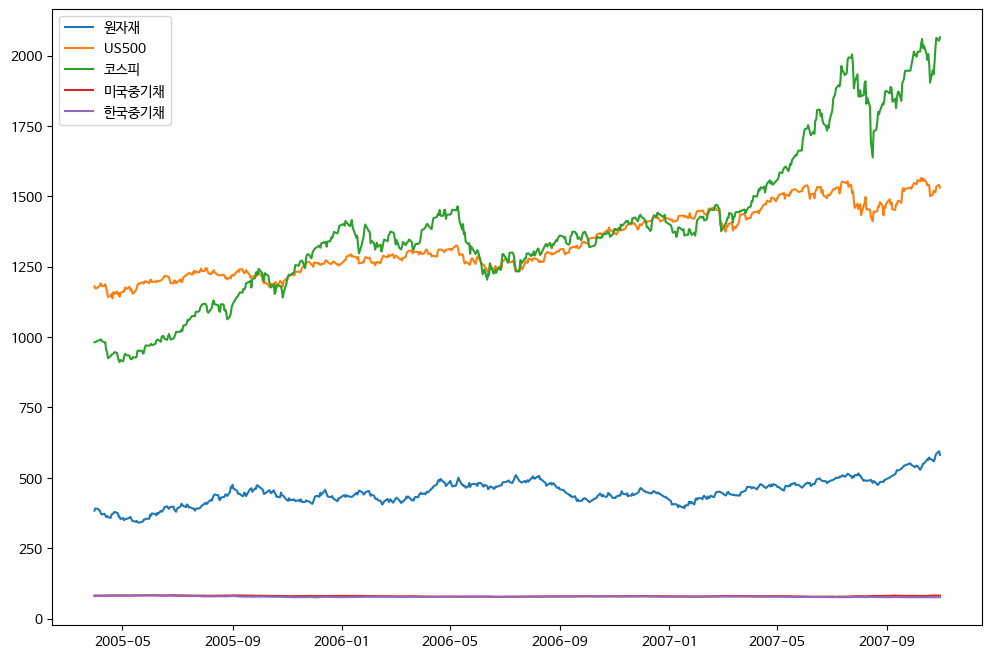

In [18]:
# 데이터 시각화
plt.figure(figsize=(12, 8))
plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(12, 8))
# 각 칼럼에 대한 선 그래프 그리기
for column in df_asset_3국면.columns:
    plt.plot(df_asset_3국면[column], label=column)
# 범례 추가
plt.legend()
# 그래프 표시
plt.show()

<Figure size 1200x800 with 0 Axes>

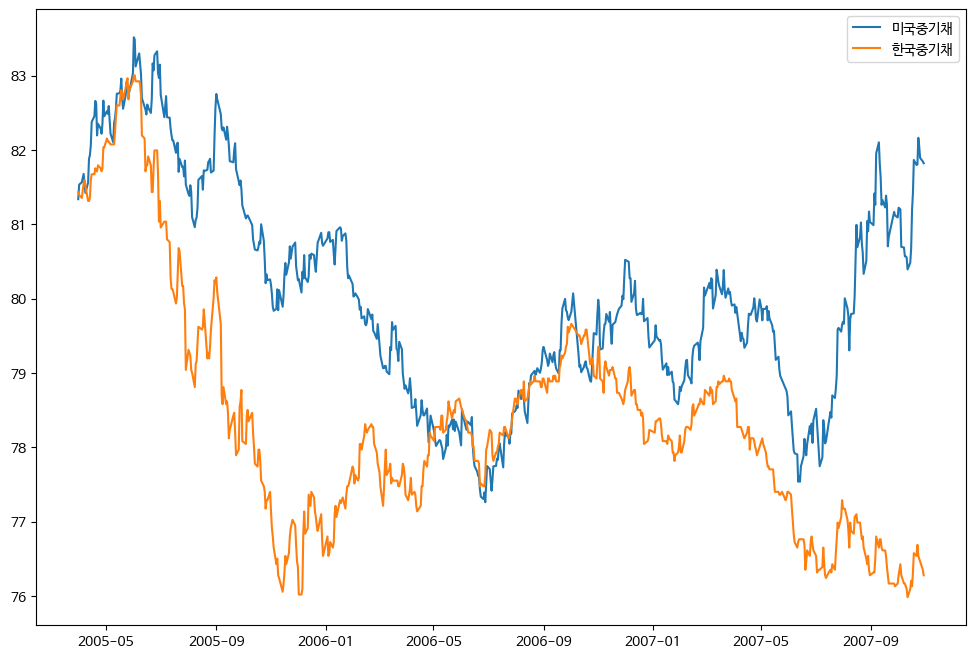

In [19]:
# 데이터 시각화
plt.figure(figsize=(12, 8))
plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(12, 8))
# 각 칼럼에 대한 선 그래프 그리기
df2_asset = df_asset_3국면[['미국중기채','한국중기채']]

for column in df2_asset.columns:
    plt.plot(df2_asset[column], label=column)
# 범례 추가
plt.legend()
# 그래프 표시
plt.show()

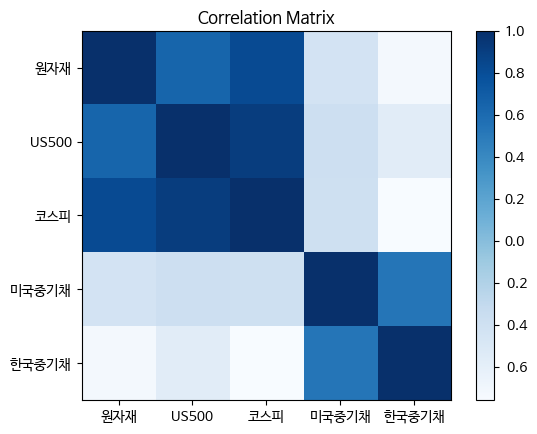

In [21]:
# 3국면 상관관계
import matplotlib.pyplot as plt
# 상관행렬 계산
Corr = df_asset_3국면.corr()
plt.figure()
plt.rc('font', family='NanumBarunGothic')
plt.title('Correlation Matrix')
plt.imshow(Corr, cmap=plt.cm.Blues)
plt.xticks(range(len(df_asset_3국면.columns)),df_asset_3국면.columns)
plt.yticks(range(len(df_asset_3국면.columns)),df_asset_3국면.columns)
plt.colorbar()
plt.show()

In [22]:
Corr

,원자재,US500,코스피,미국중기채,한국중기채
원자재,1.000000,0.635797,0.815222,-0.442462,-0.719559
US500,0.635797,1.000000,0.904650,-0.384077,-0.567847
코스피,0.815222,0.904650,1.000000,-0.393049,-0.760631
미국중기채,-0.442462,-0.384077,-0.393049,1.000000,0.531277
한국중기채,-0.719559,-0.567847,-0.760631,0.531277,1.000000


In [23]:
daily_ret = df_asset_3국면.pct_change()
daily_ret = daily_ret.fillna(0)
# 252는 평균 개장일 (미국기준)
annual_ret = daily_ret.mean() * 252
daily_cov = daily_ret.cov()
annual_cov = daily_cov * 252


# 수익률 데이터 확인 , YTM => 채권 현재 가격으로할 경우 매우 ETF와 괴리가 있으니
#채권 데이터를 어떻게 조정해야할지 생각하기.
df_sorted = daily_ret.sort_values(by='미국중기채', ascending=False)
df_sorted

,원자재,US500,코스피,미국중기채,한국중기채
Date,,,,,
2007-08-16,-0.022612,-0.010704,-0.031862,0.011861,0.000487
2007-09-07,0.002469,-0.016908,-0.026012,0.008512,0.003903
2007-07-26,-0.006544,-0.023338,-0.040906,0.007798,0.002926
2006-08-16,-0.010303,0.021463,0.009250,0.006857,0.001955
2007-02-27,-0.003725,-0.034725,-0.025615,0.006819,0.000000
...,...,...,...,...,...
2007-08-08,-0.001018,0.014072,0.002769,-0.005701,-0.002917
2007-10-05,-0.003533,0.009560,0.008412,-0.006247,-0.001945
2006-11-03,0.013544,-0.002223,-0.003389,-0.006819,-0.005358


In [24]:
df_asset_3국면.columns

Index(['원자재', 'US500', '코스피', '미국중기채', '한국중기채'], dtype='object')

In [25]:
assets = ['원자재','S&P500','코스피','미국중기채','한국중기채']

Text(2720    0.08374
Name: Risk, dtype: float64, 2720    0.154863
Name: Returns, dtype: float64, '최대 샤프지수')

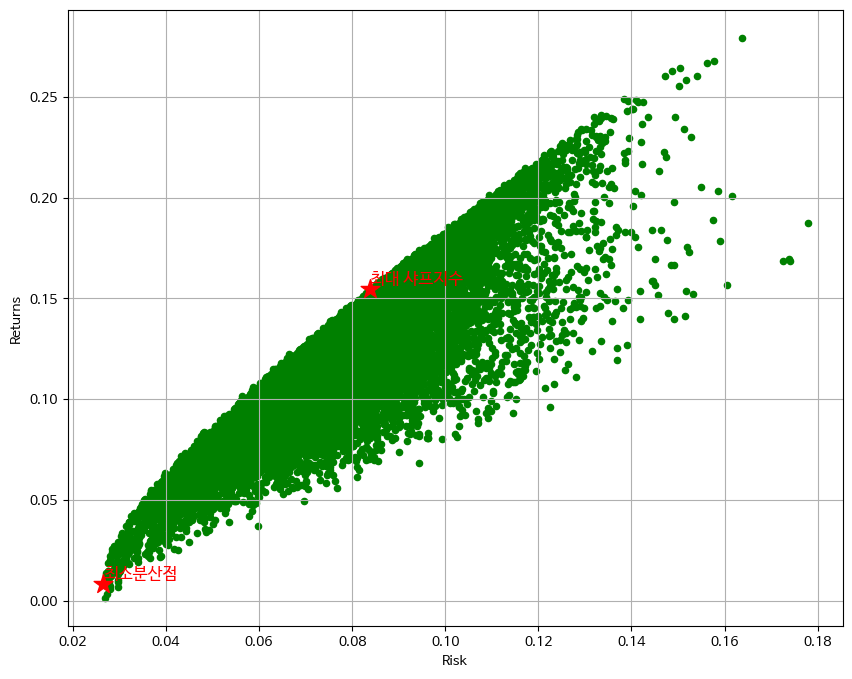

In [26]:
# 1. 수익률, 리스크, 비중 list 생성
# 수익률 = port_ret
# 리스크 = port_risk
# 비  중 = port_weights
port_ret = []
port_risk = []
port_weights = []
np.random.seed(42)
for i in range(20000):
    # 2. 랜덤 숫자 5개 생성 - 랜덤숫자 5개의 합 = 1이되도록 생성
    weights = np.random.random(len(assets))# 5개의 칼럼별로 랜덤 숫자 생성
    weights /= np.sum(weights) # 합이 1이되도록
    # 3. 랜덤 생성된 종목별 비중 배열과 종목별 연간 수익률을 곱해 포트폴리오의 전체 수익률(returns)를 구한다.
    returns = np.dot(weights, annual_ret)
    # 4. 종목별 연간공분산과 종목별 비중배열 곱하고, 다시 종목별 비중의 전치로 곱한다.
    # 결과값의 제곱근을 sqrt()함수로 구하면 해당 포트폴리오 전체 risk가 구해진다.
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))

    # 5. 20,000개 포트폴리오의 수익률, 리스크, 종목별 비중을 각각 리스트에 추가한다.
    port_ret.append(returns)
    port_risk.append(risk)
    port_weights.append(weights)

portfolio = {'Returns' : port_ret, 'Risk' : port_risk}
for j, s in enumerate(assets):
    # 6. portfolio 5종목의 가중치 weights를 1개씩 가져온다.
    portfolio[s] = [weight[j] for weight in port_weights]

# 7. 최종 df는  5종목의 보유 비중에 따른 risk와 예상 수익률을 확인할 수 있다.
df = pd.DataFrame(portfolio)
df = df[['Returns', 'Risk'] + [s for s in assets]]
# 최소분산점 찾기
min_risk_point = df[df['Risk'] == df['Risk'].min()]
# 최대 샤프지수점 찾기
df['Sharp'] = df['Returns']/df['Risk']
max_sharp_point = df[df['Sharp'] == df['Sharp'].max()]
# 8. 효율적 투자선  그래프 그리기
plt.rc('font', family='NanumBarunGothic')
df.plot.scatter(x='Risk', y='Returns', color ='g', figsize=(10,8), grid=True)
# 최소분산점 표시
plt.scatter(min_risk_point['Risk'], min_risk_point['Returns'], color='red', marker='*', s=200, label='Min Risk Point')
plt.text(min_risk_point['Risk'], min_risk_point['Returns'],'최소분산점', fontsize=12, color='red', verticalalignment='bottom')
# 최대 샤프지수점 표시
plt.scatter(max_sharp_point['Risk'], max_sharp_point['Returns'], color='red', marker='*', s=200, label='Max_Sharp_Point')
plt.text(max_sharp_point['Risk'], max_sharp_point['Returns'],'최대 샤프지수', fontsize=12, color='red', verticalalignment='bottom')

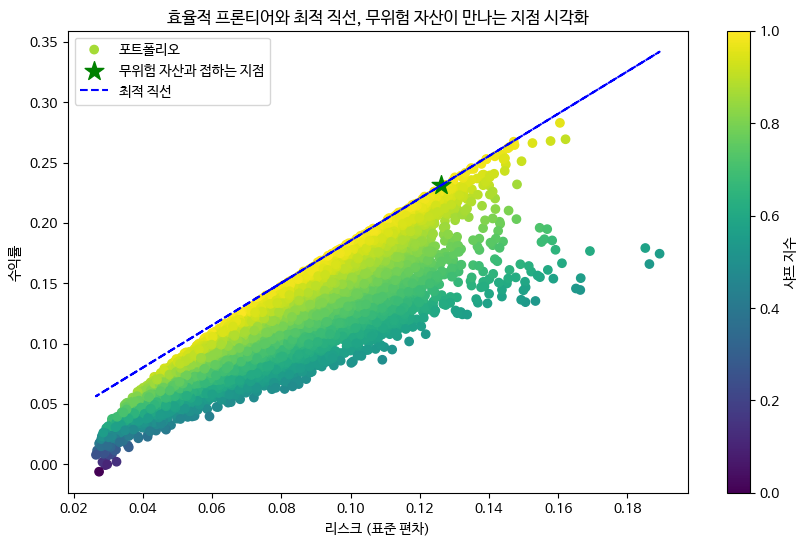

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 각 주식의 시가총액 5순위 종목 비중을 다르게 설정
init_weights = [0.2, 0.2, 0.2, 0.2, 0.2]

# 가격 데이터 가져오기 (예시로 임의의 데이터를 사용합니다.)
# 주식 데이터를 가져오는 코드가 따로 필요합니다.
# 아래는 임의의 데이터로 예시를 보여주기 위한 코드입니다.

# 최소 리스크 포트폴리오 계산 함수
def min_risk(weights, cov_matrix):
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_risk

# 최소화할 목적 함수 정의
def objective(weights, risk_free_rate, exp_ret, cov_matrix):
    port_ret = np.dot(weights, exp_ret)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    cal_slope = (port_ret - risk_free_rate) / port_risk
    return -cal_slope  # 최대 기울기를 찾기 위해 음수로 반환

# 자산 비중의 합이 1이 되는 제약 조건
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# 최적 직선의 가중치 찾기
tangent_result = minimize(objective, init_weights, args=(0.01, annual_ret, annual_cov),
                          method='SLSQP', bounds=[(0, 1)] * len(assets), constraints=constraints)

# 최적 직선의 가중치
tangent_weights = tangent_result.x

# 최적 직선의 기울기
cal_slope = (np.dot(tangent_weights, annual_ret) - 0.01) / np.sqrt(np.dot(tangent_weights.T, np.dot(annual_cov, tangent_weights)))

# 최적 직선과 효율적 프론티어가 만나는 지점 찾기
tangent_result = minimize(objective, tangent_weights, args=(0.01, annual_ret, annual_cov),
                          method='SLSQP', bounds=[(0, 1)] * len(assets), constraints=constraints)

# 최적 직선과 효율적 프론티어가 만나는 지점의 가중치
tangent_weights = tangent_result.x

# 최적 직선과 효율적 프론티어가 만나는 지점의 수익률과 리스크 계산
tangent_portfolio_ret = np.dot(tangent_weights, annual_ret)
tangent_portfolio_risk = np.sqrt(np.dot(tangent_weights.T, np.dot(annual_cov, tangent_weights)))

# 20,000개의 포트폴리오 생성
portfolios = 20000
port_ret = []
port_risk = []
port_weights = []

for i in range(portfolios):
    weights = np.random.random(len(assets))
    weights /= np.sum(weights)
    returns = np.dot(weights, annual_ret)
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))

    port_ret.append(returns)
    port_risk.append(risk)
    port_weights.append(weights)

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(port_risk, port_ret, c=np.array(port_ret)/np.array(port_risk), cmap='viridis', marker='o', label='포트폴리오')
plt.scatter(tangent_portfolio_risk, tangent_portfolio_ret, marker='*', color='g', s=200, label='무위험 자산과 접하는 지점')

# 최적 직선 표시
cal_line = 0.01 + cal_slope * np.array(port_risk)
plt.plot(port_risk, cal_line, linestyle='--', color='blue', label='최적 직선')

plt.title('효율적 프론티어와 최적 직선, 무위험 자산이 만나는 지점 시각화')
plt.xlabel('리스크 (표준 편차)')
plt.ylabel('수익률')
plt.colorbar(label='샤프 지수')
plt.legend()
plt.show()

In [28]:
# 접점의 수익률
tangent_portfolio_ret

0.23102143601185102

In [29]:
# 접점의 리스크
tangent_portfolio_risk

0.1260905031330373

In [30]:
df.sort_values(by='Returns', inplace = True)
df = df.reset_index(drop=True)

In [33]:
# 근사치로 찾기, 리턴과 리스크가 비슷한 것, ROUND 숫자 = 반올림해서 남길 소수점 자리
df['Returns_round'] = df['Returns'].round(3)
df[df['Returns_round']== tangent_portfolio_ret.round(3)]

,Returns,Risk,원자재,S&P500,코스피,미국중기채,한국중기채,Sharp,Returns_round
19961,0.230774,0.133342,0.049410,0.141295,0.641402,0.111478,0.056414,1.730695,0.231
19962,0.230776,0.132426,0.382603,0.126852,0.442608,0.029050,0.018887,1.742680,0.231
19963,0.231051,0.131460,0.367526,0.127536,0.452033,0.036957,0.015948,1.757576,0.231
19964,0.231330,0.128245,0.181035,0.098529,0.582343,0.042746,0.095346,1.803812,0.231


In [34]:
df.iloc[[19963]]

,Returns,Risk,원자재,S&P500,코스피,미국중기채,한국중기채,Sharp,Returns_round
19963,0.231051,0.13146,0.367526,0.127536,0.452033,0.036957,0.015948,1.757576,0.231


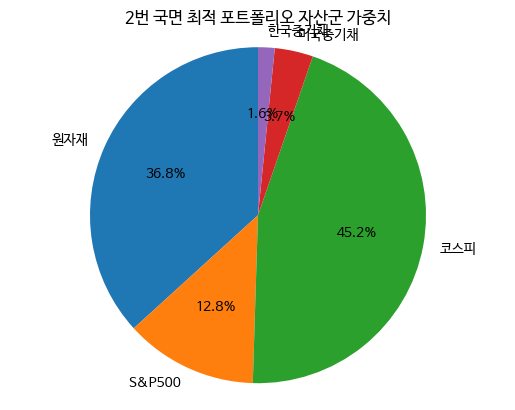

In [35]:
# 효율적 포트폴리오의 가중치
import pandas as pd
import matplotlib.pyplot as plt

row = df.iloc[19963][['원자재','S&P500','코스피','미국중기채','한국중기채']]
plt.pie(row, labels=row.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # 원형을 유지하기 위해 설정
plt.title('2번 국면 최적 포트폴리오 자산군 가중치')
plt.show()